In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA.wrapper_wandb import wrapper_tools

import os
import torch
import numpy as np

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

In [2]:
config_path = "/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/configs/config_example_DA.yaml"

run_name = "09_wrapped_DA"

In [3]:
config, dset_train, dset_val, model_encoder, model_downstream, min_val_loss = wrapper_tools.wrapper_train_models_from_config(
    config_path, run_name, default_overwrite=False
)

2025-05-17 14:50:51,129 - INFO - 🔍 Checking for config file at: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/configs/config_example_DA.yaml
2025-05-17 14:50:51,133 - INFO - ✅ Successfully loaded config file: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/configs/config_example_DA.yaml
2025-05-17 14:50:51,133 - INFO - N_threads: 1
2025-05-17 14:50:51,134 - INFO - 📦 Starting full data preparation pipeline...
2025-05-17 14:50:51,134 - INFO - 

1️⃣: Loading datasets from disk...
2025-05-17 14:50:51,134 - INFO - 📥 Starting full dataset loading with `load_dsets()`
2025-05-17 14:50:51,134 - INFO - ├ Loading JPAS datasets...
2025-05-17 14:50:51,134 - INFO - ├─── 📥 Starting JPAS dataset loading...
2025-05-17 14:50:51,135 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-05-17 14:50:51,177 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-05-17 14:50:51,189 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (520

/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/JPAS_DA/utils/plotting_utils.py:469: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


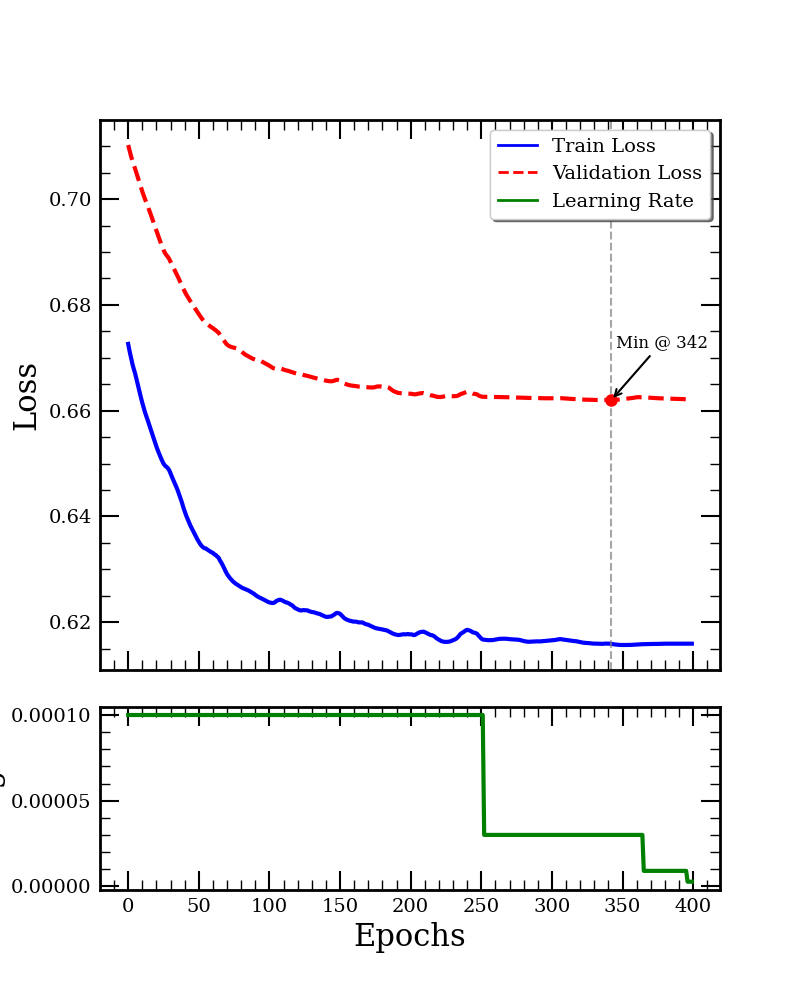

In [4]:
plotting_utils.plot_training_curves(config["training"]["path_save"])

In [5]:
device = next(model_encoder.parameters()).device

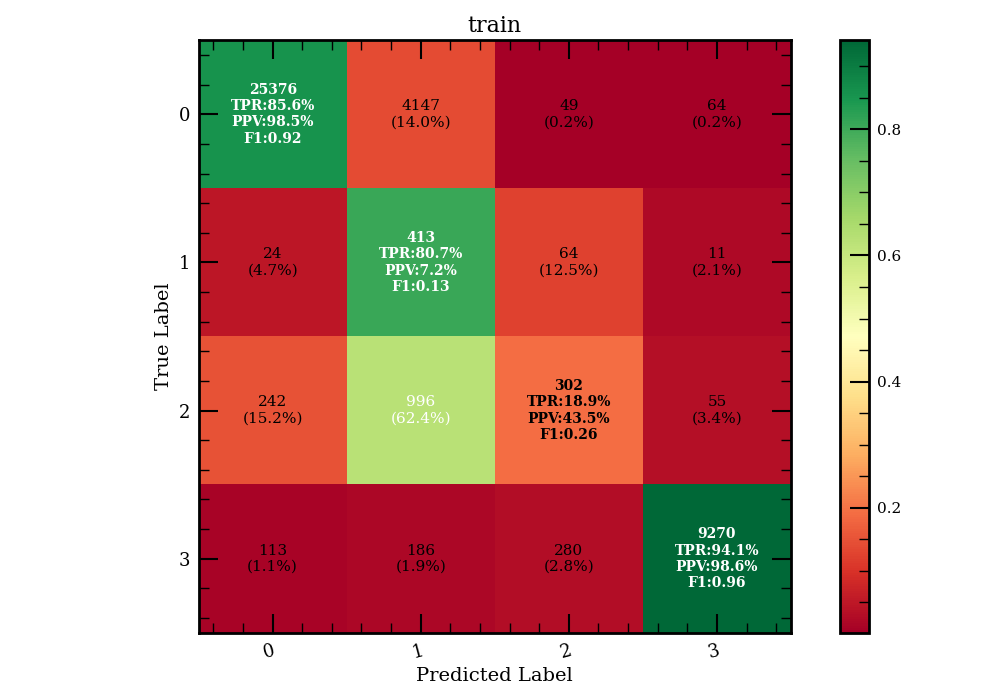

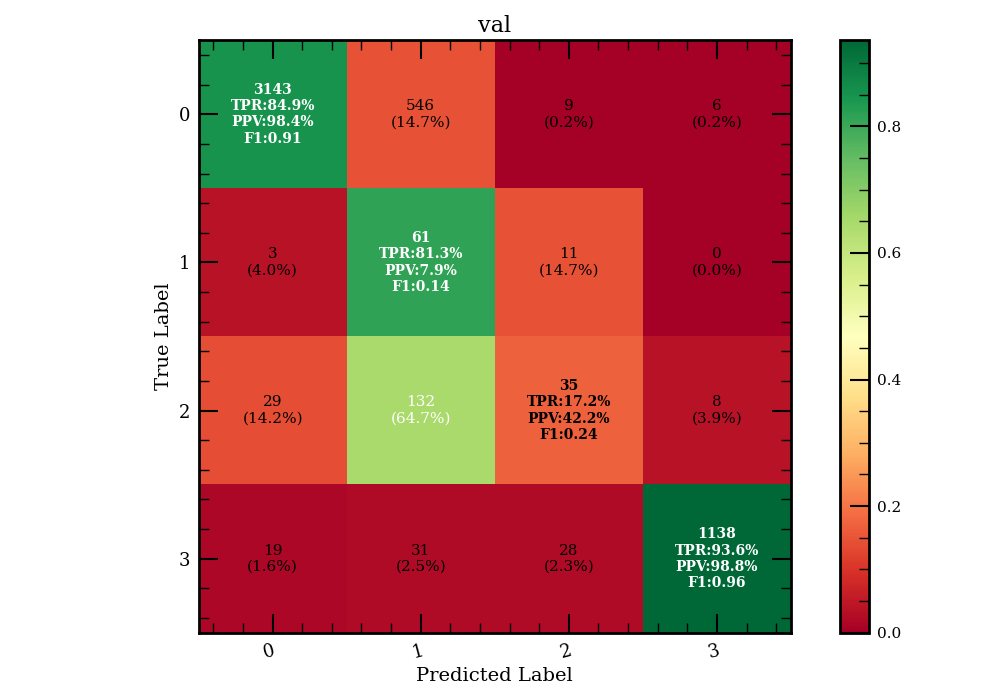

In [6]:
# === Train ===
xx_train, yy_true_train = dset_train(batch_size=dset_train.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)
with torch.no_grad():
        features_train = model_encoder(xx_train)
        logits = model_downstream(features_train)
yy_pred_P_train = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_train = yy_pred_P_train.cpu().numpy()
yy_pred_train = np.argmax(yy_pred_P_train, axis=1)
yy_true_train = yy_true_train.cpu().numpy()
xx_train = xx_train.cpu().numpy()
features_train = features_train.cpu().numpy()

plotting_utils.plot_confusion_matrix(
    yy_true_train, yy_pred_P_train,
    class_names=np.arange(len(dset_train.class_labels)),
    cmap=plt.cm.RdYlGn, title="train"
)


# === Val ===
xx_val, yy_true_val = dset_val(batch_size=dset_val.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_val = model_encoder(xx_val)
        logits = model_downstream(features_val)
yy_pred_P_val = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_val = yy_pred_P_val.cpu().numpy()
yy_pred_val = np.argmax(yy_pred_P_val, axis=1)
yy_true_val = yy_true_val.cpu().numpy()
xx_val = xx_val.cpu().numpy()
features_val = features_val.cpu().numpy()

plotting_utils.plot_confusion_matrix(
    yy_true_val, yy_pred_P_val,
    class_names=np.arange(len(dset_train.class_labels)),
    cmap=plt.cm.RdYlGn, title="val"
)